In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 기본 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 모델 라이브러리
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb

# 평가 및 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SHAP (선택사항)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP 라이브러리가 설치되지 않았습니다. pip install shap 실행하세요.")
    SHAP_AVAILABLE = False

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('df_processed.csv')

In [3]:
data.shape

(405, 43)

In [5]:
# 1-1. 원-핫 인코딩 (Categorical Variable Encoding)
df_encoded = pd.get_dummies(data, columns=['scenario'], drop_first=True)

# 1-2. 피처 스케일링 (Feature Scaling)
# VIF 계산에는 스케일링이 영향을 주지 않으므로, 예측 변수(X)만 정의합니다.
# Target 변수(예: 'Leaf_TPC')와 outlier 플래그는 VIF 계산에서 제외
target_vars = ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
outlier_flags = [col for col in df_encoded.columns if '_outlier' in col]
X = df_encoded.drop(columns=target_vars + outlier_flags)


# 2. VIF 계산
# 숫자형 데이터만 선택
X_numeric = X.select_dtypes(include='number')

# VIF 계산을 위한 데이터프레임 생성
vif = pd.DataFrame()
vif["variables"] = X_numeric.columns
vif["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# VIF가 높은 순으로 정렬하여 출력
vif_sorted = vif.sort_values('VIF', ascending=False).reset_index(drop=True)

print(vif_sorted)

               variables           VIF
0                 ABS-RC  2.762889e+07
1                 Tro-RC  1.663383e+07
2                   TChl  3.107446e+06
3                  Chl_a  1.913803e+06
4                 Dio-RC  1.508403e+06
5                  Chl_b  1.468908e+05
6                   Temp  4.227472e+04
7                    VPD  2.360649e+04
8                  Fv-Fm  8.393868e+03
9                 Eto-RC  1.932236e+03
10               SFI_abs  1.830192e+03
11               TCh-Car  1.265017e+03
12                   Car  1.246648e+03
13                DF_abs  1.039308e+03
14                 Humid  8.825728e+02
15                 month  8.217282e+02
16                PI_abs  5.135571e+02
17  Root_ExtractionYield  1.926749e+02
18  Leaf_ExtractionYield  8.619816e+01
19                CO2ppm  5.208860e+01
20               Chl_a_b  7.607360e+00


### 모델 

In [6]:
# 타겟 변수 및 outlier 플래그는 제외
target_vars = ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
outlier_flags = [col for col in df_encoded.columns if '_outlier' in col]
X = df_encoded.drop(columns=target_vars + outlier_flags)
X_numeric = X.select_dtypes(include='number')

In [7]:
# --- 1단계: 의미 기반 그룹화 및 대표 변수 선택 ---

# 제거할 변수 목록
vars_to_remove = [
    # 1. 광합성 색소 그룹: TChl(총 엽록소)을 대표로 사용하고 나머지를 제거
    'Chl_a', 'Chl_b', 'Car',
    
    # 2. 광합성 반응 중심(RC) 그룹: ABS-RC를 대표로 사용하고 나머지를 제거
    'Tro-RC', 'Dio-RC', 'Eto-RC',
    
    # 3. 기후 그룹: Temp(온도)를 대표로 사용하고 VPD를 제거
    'VPD'
]

X_manual_selection = X_numeric.drop(columns=vars_to_remove)

print("--- 1단계: 의미 기반 변수 선택 후 남은 변수 ---")
print(X_manual_selection.columns.tolist())
print("\n")

--- 1단계: 의미 기반 변수 선택 후 남은 변수 ---
['month', 'CO2ppm', 'Temp', 'Humid', 'TChl', 'Chl_a_b', 'TCh-Car', 'ABS-RC', 'PI_abs', 'DF_abs', 'SFI_abs', 'Fv-Fm', 'Leaf_ExtractionYield', 'Root_ExtractionYield']




In [13]:
# --- 1단계: 보호할 변수 직접 지정 ---
# 프로젝트 해석에 필수적이라고 생각하는 변수들을 이 리스트에 추가하세요.
PROTECTED_VARS = [
    'Temp', 'Humid', 'CO2ppm',  # 환경 정보
    'TChl',                     # 생리 반응 (색소 대표)
    'PI_abs', 'Fv-Fm',          # 생리 반응 (광합성 대표)
    'Leaf_ExtractionYield', 'Root_ExtractionYield' # 생리 활성 정보
]

# --- 2단계: 유연한 기준으로 VIF 처리 ---
# VIF 임계값을 20 또는 30 등으로 완화하여 설정
VIF_THRESHOLD = 20.0

def flexible_vif_removal(df, protected_vars, vif_threshold):
    variables = df.copy()
    
    while True:
        vif = pd.DataFrame()
        vif["Variable"] = variables.columns
        vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
        
        # 보호 변수를 제외하고 가장 높은 VIF 값 찾기
        vif_subset = vif[~vif['Variable'].isin(protected_vars)]
        
        if vif_subset.empty:
            print("보호 변수를 제외한 모든 변수가 정리되었습니다.")
            break
            
        max_vif = vif_subset['VIF'].max()
        
        if max_vif > vif_threshold:
            variable_to_remove = vif_subset.sort_values('VIF', ascending=False)['Variable'].iloc[0]
            variables = variables.drop(columns=[variable_to_remove])
            print(f"VIF가 {max_vif:.2f}로 높은 '{variable_to_remove}' 변수를 제거합니다. (보호 변수 제외)")
        else:
            print(f"\n보호 변수를 제외한 모든 변수의 VIF가 {vif_threshold} 미만이므로 처리를 종료합니다.")
            break
            
    return variables, vif.sort_values('VIF', ascending=False)


# --- 코드 실행 ---
final_variables_df, final_vif_df = flexible_vif_removal(
    df=X_numeric, 
    protected_vars=PROTECTED_VARS, 
    vif_threshold=VIF_THRESHOLD
)

# --- 최종 결과 확인 ---
print("\n--- 최종 선택된 변수 목록 ---")
print(final_variables_df.columns.tolist())

print("\n--- 최종 VIF 값 ---")
print(final_vif_df)

VIF가 27628891.38로 높은 'ABS-RC' 변수를 제거합니다. (보호 변수 제외)
VIF가 1903612.59로 높은 'Chl_a' 변수를 제거합니다. (보호 변수 제외)
VIF가 21494.36로 높은 'VPD' 변수를 제거합니다. (보호 변수 제외)
VIF가 1852.81로 높은 'Tro-RC' 변수를 제거합니다. (보호 변수 제외)
VIF가 1773.23로 높은 'SFI_abs' 변수를 제거합니다. (보호 변수 제외)
VIF가 1209.53로 높은 'TCh-Car' 변수를 제거합니다. (보호 변수 제외)
VIF가 618.23로 높은 'month' 변수를 제거합니다. (보호 변수 제외)
VIF가 259.85로 높은 'Dio-RC' 변수를 제거합니다. (보호 변수 제외)
VIF가 158.46로 높은 'Car' 변수를 제거합니다. (보호 변수 제외)
VIF가 57.43로 높은 'Eto-RC' 변수를 제거합니다. (보호 변수 제외)
VIF가 41.51로 높은 'Chl_b' 변수를 제거합니다. (보호 변수 제외)

보호 변수를 제외한 모든 변수의 VIF가 20.0 미만이므로 처리를 종료합니다.

--- 최종 선택된 변수 목록 ---
['CO2ppm', 'Temp', 'Humid', 'TChl', 'Chl_a_b', 'PI_abs', 'DF_abs', 'Fv-Fm', 'Leaf_ExtractionYield', 'Root_ExtractionYield']

--- 최종 VIF 값 ---
               Variable          VIF
7                 Fv-Fm  1973.126042
2                 Humid   621.092987
1                  Temp   492.089417
9  Root_ExtractionYield    86.475245
5                PI_abs    30.557339
3                  TChl    27.542038
8  Leaf_E

In [14]:
final_variables_df

,CO2ppm,Temp,Humid,TChl,Chl_a_b,PI_abs,DF_abs,Fv-Fm,Leaf_ExtractionYield,Root_ExtractionYield
0,381.681033,16.918639,81.750838,11.00,3.97,2.128,0.328,0.8300,19.00,18.90
1,374.463441,16.922124,81.750838,11.55,3.52,1.935,0.287,0.8260,20.10,19.60
2,371.850683,16.930256,81.750838,12.10,3.96,2.421,0.384,0.8280,20.70,20.40
3,400.475202,16.921511,81.750838,11.79,3.80,3.187,0.503,0.8390,19.00,18.90
4,381.360788,16.921323,81.750838,13.11,4.08,2.012,0.304,0.8320,20.10,19.60
...,...,...,...,...,...,...,...,...,...,...
400,1208.463000,25.901000,60.192000,3.15,5.09,0.237,-0.626,0.7220,7.10,14.60
401,1211.911000,25.896000,60.254000,5.86,4.22,0.148,-0.829,0.6452,7.05,14.55
402,1206.015000,25.923000,59.200486,2.60,31.49,0.132,-0.849,0.6452,7.00,14.50
403,1225.166000,25.890000,59.200486,3.02,6.73,0.333,-0.478,0.7270,7.10,14.60


### 모델 학습

In [19]:
df_encoded

,month,CO2ppm,Temp,Humid,VPD,Chl_a,Chl_b,TChl,Car,Chl_a_b,...,Tro-RC_outlier,Eto-RC_outlier,PI_abs_outlier,SFI_abs_outlier,Leaf_ExtractionYield_outlier,Root_ExtractionYield_outlier,Leaf_TFC_outlier,Root_TFC_outlier,scenario_SSP3,scenario_SSP5
0,5,381.681033,16.918639,81.750838,1.532512,8.79,2.22,11.00,2.97,3.97,...,0,0,0,0,0,1,0,0,False,False
1,5,374.463441,16.922124,81.750838,1.532868,8.99,2.56,11.55,3.09,3.52,...,0,0,0,0,0,1,0,0,False,False
2,5,371.850683,16.930256,81.750838,1.534584,9.66,2.44,12.10,3.11,3.96,...,0,0,0,0,0,1,0,0,False,False
3,5,400.475202,16.921511,81.750838,1.534512,9.33,2.45,11.79,3.13,3.80,...,0,0,0,0,0,1,0,0,False,False
4,5,381.360788,16.921323,81.750838,1.531475,10.53,2.58,13.11,3.37,4.08,...,0,0,0,0,0,1,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,9,1208.463000,25.901000,60.192000,2.560000,2.64,0.52,3.15,1.07,5.09,...,0,0,0,0,0,0,0,0,False,True
401,9,1211.911000,25.896000,60.254000,2.559000,4.74,1.12,5.86,1.53,4.22,...,0,0,0,0,0,0,0,0,False,True
402,9,1206.015000,25.923000,59.200486,2.565000,2.52,0.08,2.60,1.38,31.49,...,0,0,0,0,0,0,0,0,False,True
403,9,1225.166000,25.890000,59.200486,2.571000,2.63,0.39,3.02,1.17,6.73,...,0,0,0,0,0,0,0,0,False,True


'Leaf_TPC' 예측 모델의 성능 (RMSE): 0.0684
  - 평균 제곱 오차 (MSE): 0.0047
  - R-squared (설명력): 0.9800


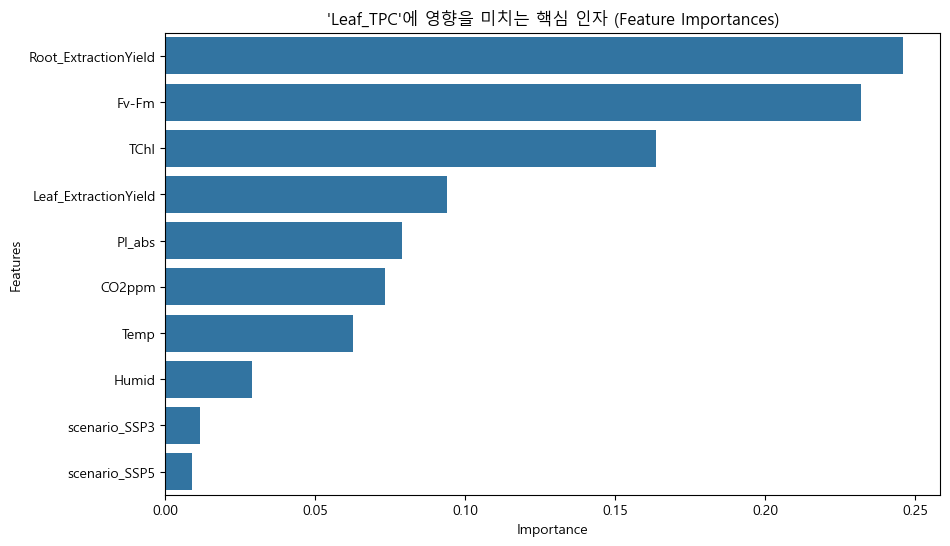


--- 핵심 인자 순위 ---
Root_ExtractionYield    0.246139
Fv-Fm                   0.231941
TChl                    0.163653
Leaf_ExtractionYield    0.094043
PI_abs                  0.079092
CO2ppm                  0.073270
Temp                    0.062579
Humid                   0.028901
scenario_SSP3           0.011607
scenario_SSP5           0.008774
dtype: float64


In [28]:
final_independent_vars_list = [ 
    'Humid', 'CO2ppm', 'Leaf_ExtractionYield', 'PI_abs', 
    'Fv-Fm', 'TChl', 'Root_ExtractionYield', 'Temp',
    'scenario_SSP3', 'scenario_SSP5'
]

target_var = 'Leaf_TPC'

X = df_encoded[final_independent_vars_list]
y = df_encoded[target_var]

# --- 2. 훈련/테스트 데이터 분리 ---
# 데이터를 모델 학습용과 성능 평가용으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. 모델 학습 ---
# 랜덤 포레스트 모델을 생성하고 학습시킵니다.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- 4. 모델 성능 평가 ---
# 테스트 데이터로 예측을 수행하고 성능을 평가합니다.
predictions = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions) # 평균제곱오차: 예측값과 실제값의 차이를 제곱한 평균 (작을수록 좋음)
r2 = r2_score(y_test, predictions)
print(f"'{target_var}' 예측 모델의 성능 (RMSE): {rmse:.4f}")
print(f"  - 평균 제곱 오차 (MSE): {mse:.4f}")
print(f"  - R-squared (설명력): {r2:.4f}")

# --- 5. 핵심 인자 도출 (변수 중요도 시각화) ---
# 모델이 어떤 변수를 중요하게 생각하는지 확인합니다.
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title(f"'{target_var}'에 영향을 미치는 핵심 인자 (Feature Importances)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

print("\n--- 핵심 인자 순위 ---")
print(feature_importances)

'Leaf_TFC' 예측 모델의 성능 (RMSE): 0.0537
  - 평균 제곱 오차 (MSE): 0.0029
  - R-squared (설명력): 0.9996


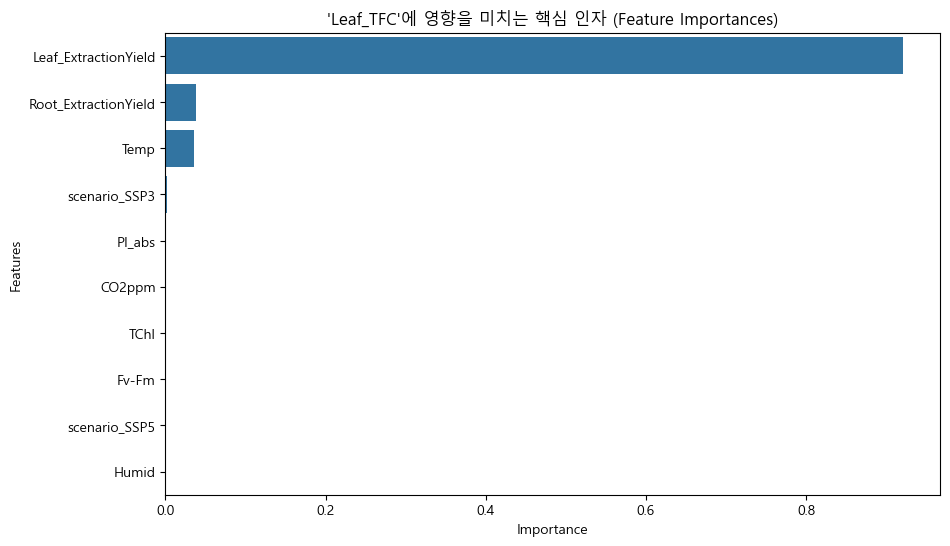


--- 핵심 인자 순위 ---
Leaf_ExtractionYield    0.921246
Root_ExtractionYield    0.038570
Temp                    0.036129
scenario_SSP3           0.002043
PI_abs                  0.000532
CO2ppm                  0.000505
TChl                    0.000321
Fv-Fm                   0.000266
scenario_SSP5           0.000249
Humid                   0.000140
dtype: float64


In [31]:
final_independent_vars_list = [ 
    'Humid', 'CO2ppm', 'Leaf_ExtractionYield', 'PI_abs', 
    'Fv-Fm', 'TChl', 'Root_ExtractionYield', 'Temp',
    'scenario_SSP3', 'scenario_SSP5'
]

target_var = 'Leaf_TFC'

X = df_encoded[final_independent_vars_list]
y = df_encoded[target_var]

# --- 2. 훈련/테스트 데이터 분리 ---
# 데이터를 모델 학습용과 성능 평가용으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. 모델 학습 ---
# 랜덤 포레스트 모델을 생성하고 학습시킵니다.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- 4. 모델 성능 평가 ---
# 테스트 데이터로 예측을 수행하고 성능을 평가합니다.
predictions = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions) # 평균제곱오차: 예측값과 실제값의 차이를 제곱한 평균 (작을수록 좋음)
r2 = r2_score(y_test, predictions)
print(f"'{target_var}' 예측 모델의 성능 (RMSE): {rmse:.4f}")
print(f"  - 평균 제곱 오차 (MSE): {mse:.4f}")
print(f"  - R-squared (설명력): {r2:.4f}")

# --- 5. 핵심 인자 도출 (변수 중요도 시각화) ---
# 모델이 어떤 변수를 중요하게 생각하는지 확인합니다.
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title(f"'{target_var}'에 영향을 미치는 핵심 인자 (Feature Importances)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

print("\n--- 핵심 인자 순위 ---")
print(feature_importances)

'Root_TPC' 예측 모델의 성능 (RMSE): 0.0294
  - 평균 제곱 오차 (MSE): 0.0009
  - R-squared (설명력): 0.9969


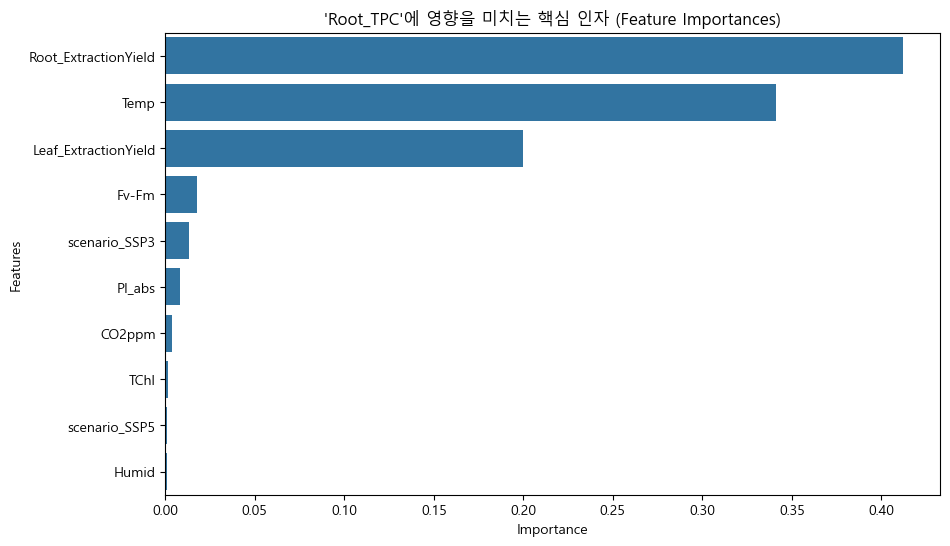


--- 핵심 인자 순위 ---
Root_ExtractionYield    0.412277
Temp                    0.340868
Leaf_ExtractionYield    0.199945
Fv-Fm                   0.017792
scenario_SSP3           0.013489
PI_abs                  0.008132
CO2ppm                  0.003735
TChl                    0.001747
scenario_SSP5           0.001076
Humid                   0.000939
dtype: float64


In [29]:
final_independent_vars_list = [ 
    'Humid', 'CO2ppm', 'Leaf_ExtractionYield', 'PI_abs', 
    'Fv-Fm', 'TChl', 'Root_ExtractionYield', 'Temp',
    'scenario_SSP3', 'scenario_SSP5'
]

target_var = 'Root_TPC'

X = df_encoded[final_independent_vars_list]
y = df_encoded[target_var]

# --- 2. 훈련/테스트 데이터 분리 ---
# 데이터를 모델 학습용과 성능 평가용으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. 모델 학습 ---
# 랜덤 포레스트 모델을 생성하고 학습시킵니다.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- 4. 모델 성능 평가 ---
# 테스트 데이터로 예측을 수행하고 성능을 평가합니다.
predictions = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions) # 평균제곱오차: 예측값과 실제값의 차이를 제곱한 평균 (작을수록 좋음)
r2 = r2_score(y_test, predictions)
print(f"'{target_var}' 예측 모델의 성능 (RMSE): {rmse:.4f}")
print(f"  - 평균 제곱 오차 (MSE): {mse:.4f}")
print(f"  - R-squared (설명력): {r2:.4f}")

# --- 5. 핵심 인자 도출 (변수 중요도 시각화) ---
# 모델이 어떤 변수를 중요하게 생각하는지 확인합니다.
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title(f"'{target_var}'에 영향을 미치는 핵심 인자 (Feature Importances)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

print("\n--- 핵심 인자 순위 ---")
print(feature_importances)

'Root_TFC' 예측 모델의 성능 (RMSE): 0.0147
  - 평균 제곱 오차 (MSE): 0.0002
  - R-squared (설명력): 0.9871


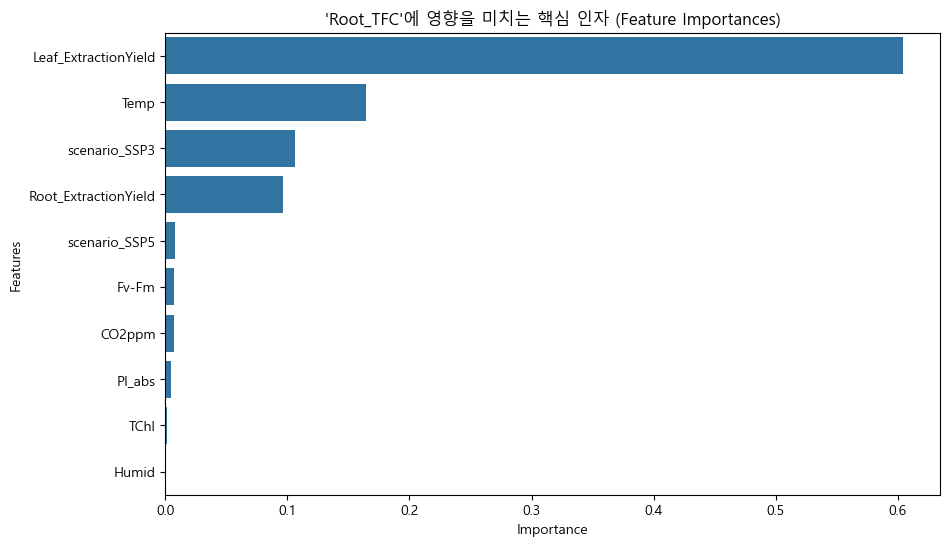


--- 핵심 인자 순위 ---
Leaf_ExtractionYield    0.604454
Temp                    0.164187
scenario_SSP3           0.105973
Root_ExtractionYield    0.096203
scenario_SSP5           0.008092
Fv-Fm                   0.007468
CO2ppm                  0.006930
PI_abs                  0.004831
TChl                    0.001710
Humid                   0.000153
dtype: float64


In [30]:
final_independent_vars_list = [ 
    'Humid', 'CO2ppm', 'Leaf_ExtractionYield', 'PI_abs', 
    'Fv-Fm', 'TChl', 'Root_ExtractionYield', 'Temp',
    'scenario_SSP3', 'scenario_SSP5'
]

target_var = 'Root_TFC'

X = df_encoded[final_independent_vars_list]
y = df_encoded[target_var]

# --- 2. 훈련/테스트 데이터 분리 ---
# 데이터를 모델 학습용과 성능 평가용으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. 모델 학습 ---
# 랜덤 포레스트 모델을 생성하고 학습시킵니다.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- 4. 모델 성능 평가 ---
# 테스트 데이터로 예측을 수행하고 성능을 평가합니다.
predictions = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions) # 평균제곱오차: 예측값과 실제값의 차이를 제곱한 평균 (작을수록 좋음)
r2 = r2_score(y_test, predictions)
print(f"'{target_var}' 예측 모델의 성능 (RMSE): {rmse:.4f}")
print(f"  - 평균 제곱 오차 (MSE): {mse:.4f}")
print(f"  - R-squared (설명력): {r2:.4f}")

# --- 5. 핵심 인자 도출 (변수 중요도 시각화) ---
# 모델이 어떤 변수를 중요하게 생각하는지 확인합니다.
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title(f"'{target_var}'에 영향을 미치는 핵심 인자 (Feature Importances)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

print("\n--- 핵심 인자 순위 ---")
print(feature_importances)


--- 순열 중요도 기반 핵심 인자 순위 ---
               Variable  Importance       Std
4                 Fv-Fm    0.389157  0.072873
6  Root_ExtractionYield    0.271074  0.036236
5                  TChl    0.142817  0.039217
2  Leaf_ExtractionYield    0.105207  0.012045
3                PI_abs    0.099803  0.016335
1                CO2ppm    0.054353  0.012535
7                  Temp    0.030039  0.004224
0                 Humid    0.017875  0.007788
8         scenario_SSP3    0.003672  0.001084
9         scenario_SSP5    0.003080  0.000808


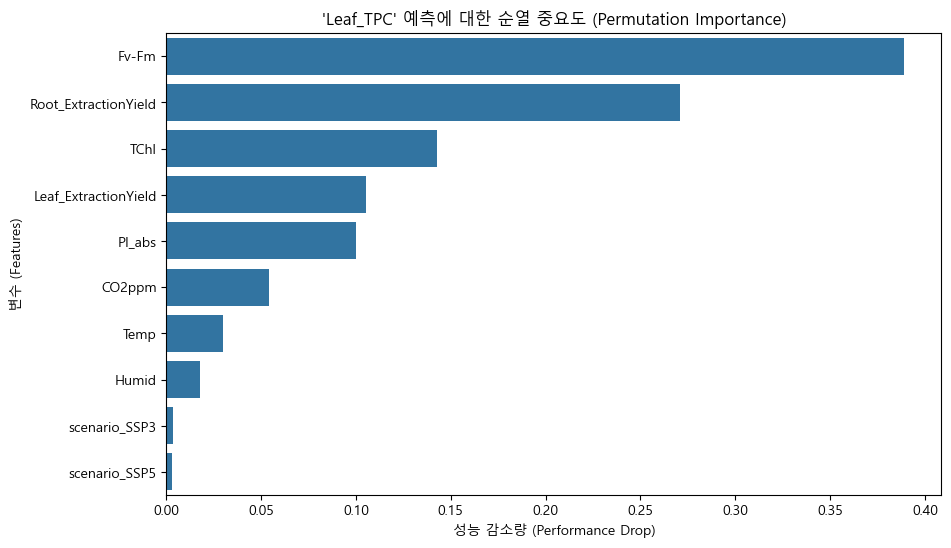

In [26]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 6. 순열 중요도(Permutation Importance) 계산 ---
# 학습된 모델(rf_model)과 테스트 데이터(X_test, y_test)를 사용합니다.
# n_repeats는 계산을 몇 번 반복할지 정하는 것이며, 많을수록 안정적인 결과를 얻습니다.
result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# --- 결과 정리 및 출력 ---
# 계산된 중요도를 데이터프레임으로 정리합니다.
perm_importances = pd.DataFrame(
    {'Variable': X_test.columns,
     'Importance': result.importances_mean,
     'Std': result.importances_std}
).sort_values('Importance', ascending=False)


print("\n--- 순열 중요도 기반 핵심 인자 순위 ---")
print(perm_importances)


# --- 시각화 ---
plt.figure(figsize=(10, 6))
# Windows 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
sns.barplot(x=perm_importances['Importance'], y=perm_importances['Variable'])
plt.title(f"'{target_var}' 예측에 대한 순열 중요도 (Permutation Importance)")
plt.xlabel("성능 감소량 (Performance Drop)")
plt.ylabel("변수 (Features)")
plt.show()